# Transfer Learning for Multi-Class Classification


This notebook is an implementation of transfer learning approach by using multi-class weather dataset for image classification task.

The dataset consists of a total of 1125 images which are maually labeled as cloudy, sunrise, rainy and sun shine. I will use pre-trained models which are ResNet and InceptionV3 available from Keras.

With transfer learning, instead of starting the learning process from scratch, we start from patterns that have been learned when solving a new related problem. So we reuse initial and middle layers of our pre-trained model to re-train only final layers for our new task. A pre-trained model denotes a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve.

![transfer-learning](image-tf.png)





In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Data preprocessing

In [18]:
import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = '/kaggle/input/chicken/Train'
data_dir = pathlib.Path(data_dir)

In [19]:
img_height,img_width=224,224
image_size= (img_height, img_width)
input_shape=(img_height,img_width, 3)
batch_size=32

In [20]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True
  )

Found 8067 files belonging to 4 classes.
Using 6454 files for training.


In [21]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8067 files belonging to 4 classes.
Using 1613 files for validation.


In [22]:
# BATCH_SIZE = 32
# IMG_SIZE = (256, 256)

# train_dataset = tf.keras.utils.image_dataset_from_directory(
#     "dataset",
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     validation_split=0.2,
#     subset="training",
#     seed=42    
# )

# validation_dataset = tf.keras.utils.image_dataset_from_directory(
#     "dataset",
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     validation_split=0.2,
#     subset="validation",
#     seed=42
# )

First nine images and labels from training set: 

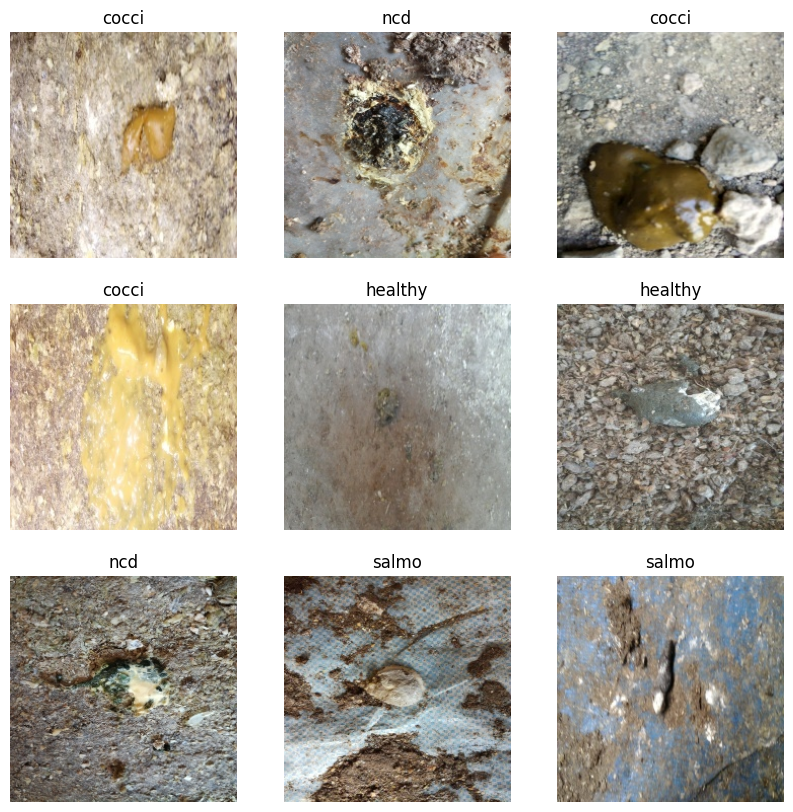

In [23]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move some of them to a test set.

In [24]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 34
Number of test batches: 17


### Configure dataset for performance

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

If the dataset is not too large, introducing sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping, helps with overfitting.

In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

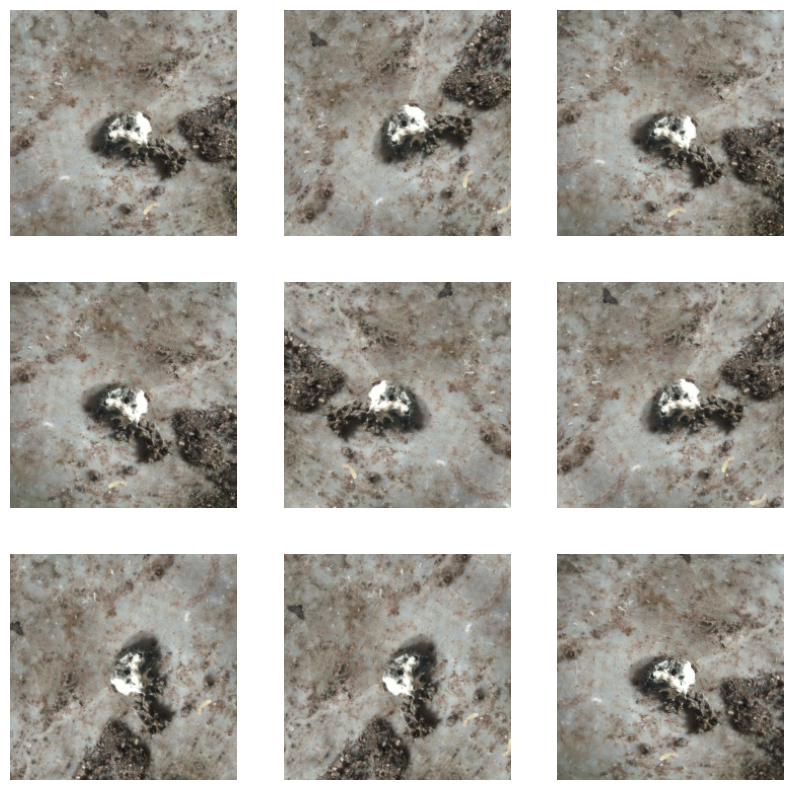

In [27]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0),training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescaling

Rescale pixel values by using the preprocessing method included with the models.

In [28]:
preprocess_input_resnet = tf.keras.applications.resnet50.preprocess_input

preprocess_input_inception = tf.keras.applications.inception_v3.preprocess_input

# Resnet50

## Create the base model from pre-trained weights

 By specifying the **include_top=False** argument, We load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [29]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False, 
    input_shape=input_shape,)

9406464/9406464 [==============================] - 0s 0us/step


### Freeze the base model

In [30]:
base_model.trainable=False

### Build a model

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the Sequential layer.

- To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single vector per image.
- Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.
- Apply a last `tf.keras.layers.Dense` layer with softmax activation to apply multi-class classification.

In [31]:
model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        data_augmentation,
        tf.keras.layers.Lambda(preprocess_input_resnet),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
    
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.4),
    
        tf.keras.layers.Dense(4, activation='softmax')
    ])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)              

### Compile and Train the Model

In [32]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
202/202 [==============================] - 15s 51ms/step - loss: 1.1511 - accuracy: 0.5175 - val_loss: 0.8046 - val_accuracy: 0.6997
Epoch 2/10
202/202 [==============================] - 8s 40ms/step - loss: 0.9017 - accuracy: 0.6607 - val_loss: 0.7326 - val_accuracy: 0.7287
Epoch 3/10
202/202 [==============================] - 8s 40ms/step - loss: 0.8197 - accuracy: 0.6869 - val_loss: 0.6658 - val_accuracy: 0.7624
Epoch 4/10
202/202 [==============================] - 8s 40ms/step - loss: 0.7638 - accuracy: 0.7209 - val_loss: 0.6332 - val_accuracy: 0.7717
Epoch 5/10
202/202 [==============================] - 8s 41ms/step - loss: 0.7177 - accuracy: 0.7374 - val_loss: 0.6300 - val_accuracy: 0.7746
Epoch 6/10
202/202 [==============================] - 8s 40ms/step - loss: 0.7078 - accuracy: 0.7443 - val_loss: 0.6088 - val_accuracy: 0.7867
Epoch 7/10
202/202 [==============================] - 8s 40ms/step - loss: 0.6778 - accuracy: 0.7619 - val_loss: 0.6094 - val_accuracy: 0.781

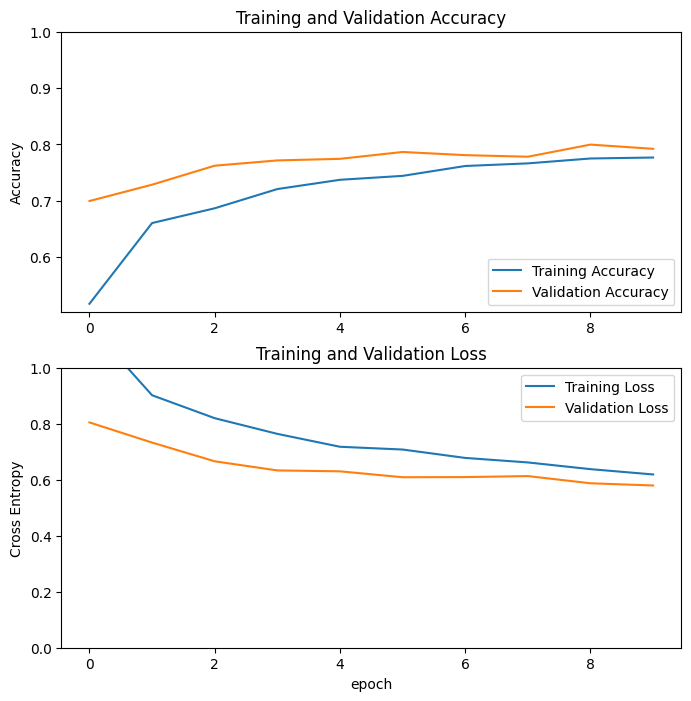

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier.

### Unfreeze the Top Layers of Base Model

Unfreeze the `base_model` and set the bottom layers to be un-trainable.

In [34]:
base_model.trainable = True

In [35]:
# How many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile and Continue Training The model

In [36]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
202/202 [==============================] - 26s 54ms/step - loss: 0.9811 - accuracy: 0.6174 - val_loss: 0.7322 - val_accuracy: 0.7605
Epoch 11/20
202/202 [==============================] - 10s 49ms/step - loss: 0.7798 - accuracy: 0.7120 - val_loss: 0.7529 - val_accuracy: 0.7661
Epoch 12/20
202/202 [==============================] - 10s 50ms/step - loss: 0.7190 - accuracy: 0.7431 - val_loss: 0.7056 - val_accuracy: 0.7774
Epoch 13/20
202/202 [==============================] - 10s 49ms/step - loss: 0.6755 - accuracy: 0.7639 - val_loss: 0.7103 - val_accuracy: 0.7755
Epoch 14/20
202/202 [==============================] - 10s 49ms/step - loss: 0.6443 - accuracy: 0.7738 - val_loss: 0.6401 - val_accuracy: 0.7942
Epoch 15/20
202/202 [==============================] - 10s 49ms/step - loss: 0.6186 - accuracy: 0.7860 - val_loss: 0.6027 - val_accuracy: 0.7998
Epoch 16/20
202/202 [==============================] - 10s 49ms/step - loss: 0.5978 - accuracy: 0.7918 - val_loss: 0.5828 - val_ac

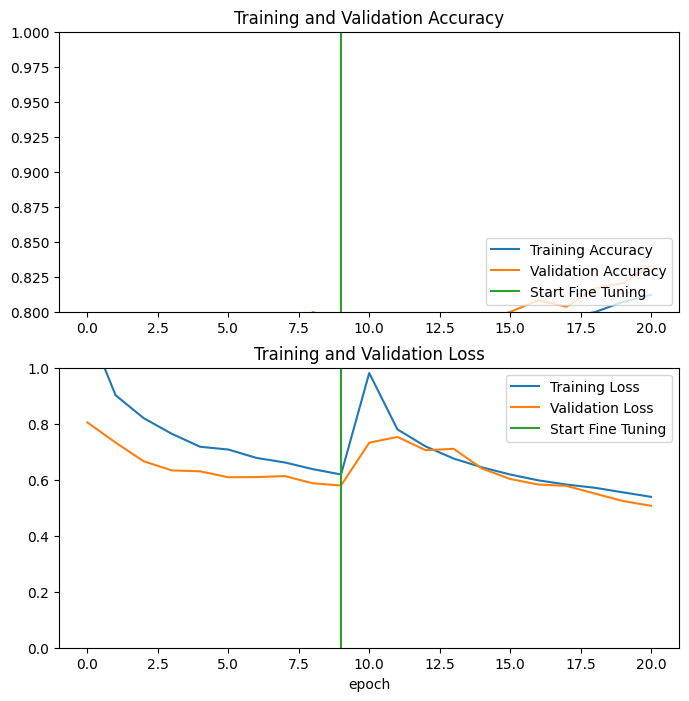

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and Prediciton

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

17/17 [==============================] - 1s 30ms/step - loss: 0.4645 - accuracy: 0.8272
Test accuracy : 0.8272058963775635


In [39]:
loss, accuracy = model.evaluate(test_dataset)
print('Validation Accuracy :', accuracy)

17/17 [==============================] - 1s 31ms/step - loss: 0.5032 - accuracy: 0.8143
Validation Accuracy : 0.814338207244873


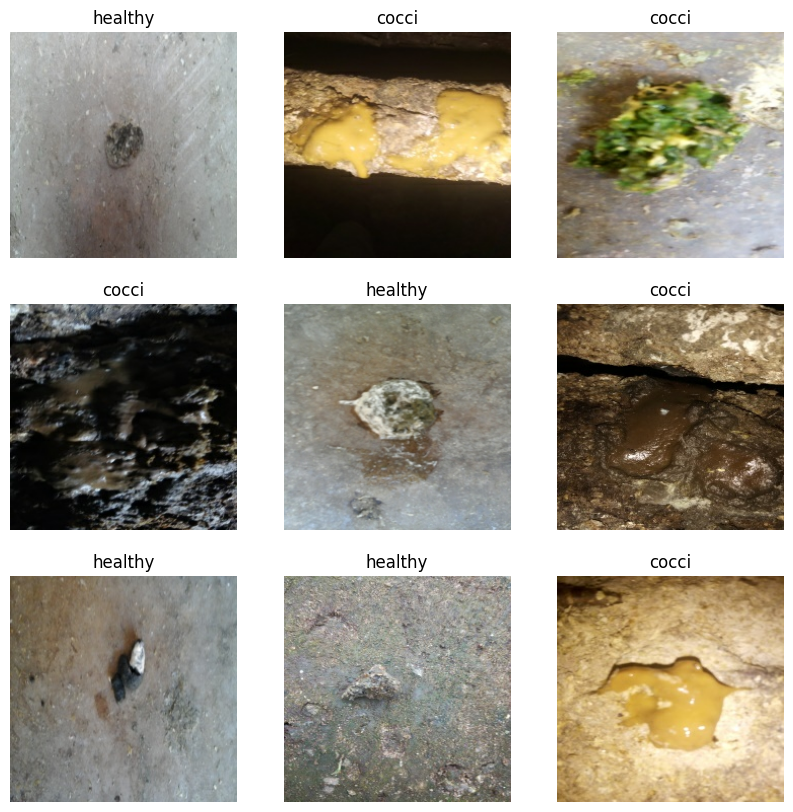

In [40]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
prediction = model.predict_on_batch(image_batch)

predictions = []

# Last layer of model is softmax: take the maximum to predict
for arr in prediction:
  predictions.append(np.argmax(arr))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [60]:
modelname="MobileNetV2"
model.save(modename)

In [61]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_MobileNetV2.tflite"

tf_lite_converter = tf.lite.TFLiteConverter.from_saved_model(f"/kaggle/working/{modelname}")
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
#tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

In [43]:
import os

In [44]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')


def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

File size: 3257.852 Kilobytes
Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>


## InceptionV3

### Create the base model and model 

In [45]:
# base_model = tf.keras.applications.InceptionV3(
#     weights='imagenet',
#     include_top=False, 
#     input_shape=(256, 256, 3))

# base_model.trainable=False

# model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=(256,256,3)),
#         data_augmentation,
#         tf.keras.layers.Lambda(preprocess_input_inception),
#         base_model,
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(512, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(4, activation='softmax')
#     ])

# model.summary()

### Compile and Train the Model

In [46]:
# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# initial_epochs = 10

# history = model.fit(train_dataset,
#                     epochs=initial_epochs,
#                     validation_data=validation_dataset)

In [47]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

### Fine Tuning

In [48]:
# base_model.trainable = True

# # How many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False

In [49]:
# model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
#               metrics=['accuracy'])

# fine_tune_epochs = 10
# total_epochs =  initial_epochs + fine_tune_epochs

# history_fine = model.fit(train_dataset,
#                          epochs=total_epochs,
#                          initial_epoch=history.epoch[-1],
#                          validation_data=validation_dataset)

In [50]:
# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']

# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

### Evaluation and Prediciton

In [51]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

In [52]:
# # Retrieve a batch of images from the test set
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# prediction = model.predict_on_batch(image_batch)

# predictions = []

# # Last layer of model is softmax: take the maximum to predict
# for arr in prediction:
#   predictions.append(np.argmax(arr))

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")